## Necessary Imports


In [1]:
import os
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from matplotlib.cm import get_cmap

## Parameters and Inputs

The Polynomial fitting data is for replacing the x-axis of the spectrograms; it allows us to transform pixel values to raman shift values. In order to calibrate the polynomial, take the measurements of a well-studied material(such as PMMA), provide the pixel values corresponding to peaks in pixelval, and provide the raman shift values corresponding to the same peaks in ramanval. You can find the shift values by finding a raman spectrogram of your chosen material from literature.

In [29]:
# Polynomial fitting data
pixelval = [116, 184.5, 251, 376, 480, 785, 974]
ramanval = [365.676, 484.588, 601, 812.223, 974.5, 1451.85, 1728.9]
#Fit Polynomial
mymodel = np.poly1d(np.polyfit(pixelval, ramanval, 3))

In [30]:
# Root directory containing your data
root_dir = r"C:\Users\batua\Downloads\Cyst-20240719T221011Z-002\Cyst"

## Preprocessing and Data Import Functions

This pipeline function allows you to chose the part of the spectra you will use using the crop_start/end parameters. Cut the parts corresponding to the background in order to make sure the baseline is not inflated. After the cropping, this pipeline function turns all values positive, removes cosmic rays using a median filter, denoises it using a savgol filter, corrects it by using baseline_als and normalises it.

In [15]:
#Preprocessing Functions
def crop_spectrum(spectrum, crop_start, crop_end):
    return spectrum[crop_start:crop_end+1]

def turn_positive(spectrum):
    data_to_adjust = spectrum
    min_value = data_to_adjust.min().min()
    constant_to_add = -min_value
    adjusted_data = data_to_adjust + constant_to_add
    spectrum = adjusted_data
    return spectrum

def despike_spectrum(spectrum, threshold=5):
    spectrum = spectrum.astype(float)
    filtered = median_filter(spectrum, size=3)
    spikes = np.abs(spectrum - filtered) > threshold
    spectrum[spikes] = filtered[spikes]
    return spectrum

def baseline_als(y, lam=1e5, p=0.01, niter=4):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    w = np.ones(L)
    for i in range(niter):
        W = np.diag(w)
        Z = W + lam * D.dot(D.T) + np.eye(L) * 1e-10  # Add small regularization term
        z = np.linalg.solve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def baseline_correction(spectrum):
    baseline = baseline_als(spectrum)
    return spectrum - baseline

def l2_normalize(spectrum):
    norm = np.linalg.norm(spectrum)
    if norm == 0:
        return spectrum
    return spectrum / norm

# Preprocess Pipeline
def preprocess(data, crop_start, crop_end=None):
    if crop_end is None:
        crop_end = data.shape[1] - 3  # Default to the length of the spectrum minus 3 (excluding CystType and PatientID)

    lb = crop_start
    ub = min(crop_end, data.shape[1] - 3)  # Adjust the upper bound to avoid exceeding the number of columns

    spectra_array = np.zeros((data.shape[0], ub - lb + 1))

    for i in tqdm(range(data.shape[0]), desc="Preprocessing spectra"):
        spectrum = data.iloc[i, :-2].to_numpy()  # Exclude the last two columns (CystType and PatientID)
        cropped_spectrum = crop_spectrum(spectrum, lb, ub)
        positive_spectrum = turn_positive(cropped_spectrum)
        despiked_spectrum = despike_spectrum(positive_spectrum)
        window_length = min(21, len(despiked_spectrum))
        if window_length % 2 == 0:
            window_length -= 1
        if window_length < 3:
            window_length = 3
        denoised_spectrum = savgol_filter(despiked_spectrum, window_length=window_length, polyorder=min(2, window_length - 1), mode='nearest')
        baseline_corrected_spectrum = baseline_correction(denoised_spectrum)
        normalized_spectrum = l2_normalize(baseline_corrected_spectrum)
        spectra_array[i, :] = normalized_spectrum

    raman_shifts = mymodel(np.arange(lb, ub + 1))
    df = pd.DataFrame(spectra_array, columns=raman_shifts)
    df['CystType'] = data['CystType']
    df['PatientID'] = data['PatientID']

    return df


This read&merge function is designed to extract raman spectrograms from a local folder, label them by their patient numbers and cyst types and merge them in an easy to use dataframe. In order to correctly use this function, the root directory should contain your raman spectrograms separated into folders based on their cyst types and patient numbers. The folder names should follow this pattern: Cysttype+Patient Number(Ex. MNG777). Additionally, this read&merge function uses the previously defined preprocessing function and the polynomial in order to prepare the data for all further processes.

In [16]:
# Function to read and merge data
def merge_data(root_dir):
    spectra_list = []
    all_files = []

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if not file.endswith('.csv'):  # Assuming files don't have .csv extension
                file_path = os.path.join(root, file)
                all_files.append(file_path)

    for file_path in tqdm(all_files, desc="Merging data"):
        parts = os.path.dirname(file_path).split(os.sep)
        cyst_type = ''.join(filter(str.isalpha, parts[-1]))
        patient_id = ''.join(filter(str.isdigit, parts[-1]))

        data = pd.read_csv(file_path, header=None)
        second_column = data.iloc[:, 1].values

        row = list(second_column) + [cyst_type, patient_id]
        spectra_list.append(row)

    merged_data = pd.DataFrame(spectra_list)

    # Open one of the CSV files to get the first column and fit it using the polynomial model
    sample_file = all_files[0]
    sample_data = pd.read_csv(sample_file, header=None)
    raman_shifts = mymodel(sample_data.iloc[:, 0].values)

    # Assign the raman_shifts as the header, adding 'CystType' and 'PatientID' at the end
    headers = list(raman_shifts) + ['CystType', 'PatientID']
    merged_data.columns = headers

    return merged_data

### Use Functions

In [ ]:
# Merge the data
merged_data = merge_data(root_dir)
print(merged_data)

# Preprocess the merged data with specified crop points
processed_df = preprocess(merged_data, 150)

# Display the first few rows of the preprocessed data
print(processed_df.head())
merged_data=processed_df

In [ ]:
merged_data.to_csv("OLDDATAFINAL.csv")

## Import Preprocessed Data

In [23]:
merged_data= pd.read_csv("OLDDATAFINAL.csv")

In [19]:
print(merged_data)

       Unnamed: 0  425.5683414276491  427.3207114147345  429.0725689939214  \
0               0          -0.003561          -0.003122          -0.002374   
1               1          -0.000362           0.000138           0.000812   
2               2           0.001654           0.002982           0.004102   
3               3           0.000909           0.002032           0.003307   
4               4           0.001002           0.002770           0.004199   
...           ...                ...                ...                ...   
12176       12176          -0.003551          -0.003150          -0.002679   
12177       12177          -0.003647          -0.003231          -0.002807   
12178       12178          -0.004212          -0.003921          -0.003266   
12179       12179          -0.004379          -0.003600          -0.002690   
12180       12180          -0.005656          -0.004811          -0.003572   

       430.8239145264233  432.5747483734538  434.32507089622646

In [24]:
merged_data = merged_data.iloc[:, 1:]
merged_data = merged_data[merged_data['CystType'] != 'PBS']

# Verify the result
print(merged_data['CystType'].value_counts())

CystType
MLG    4506
SCA    2321
PC     2196
IMG    1928
IHG     598
ILG     589
MMG      24
Name: count, dtype: int64


## Graph Preprocessed Data

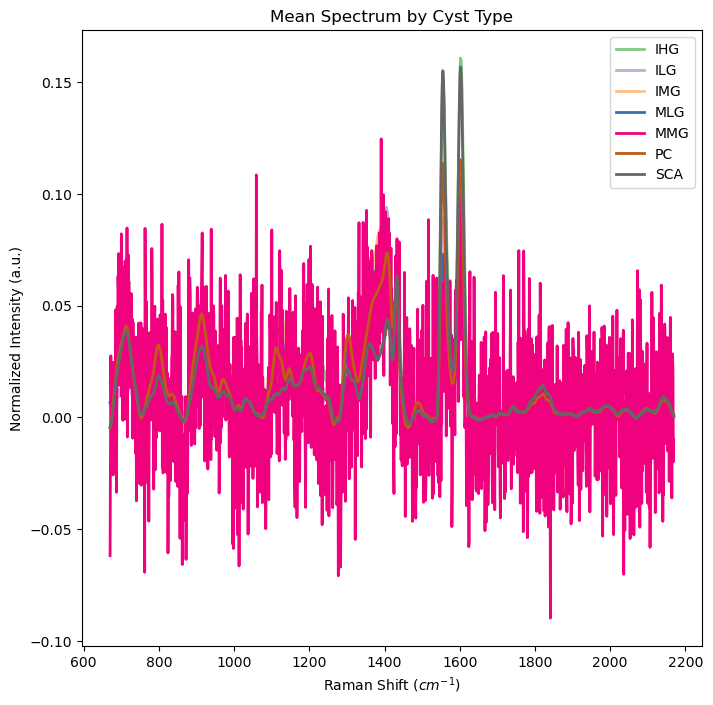

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import matplotlib as mpl

def get_cmap_safe(cmap_name):
    if mpl.__version__ >= '3.7':
        return mpl.colormaps.get_cmap(cmap_name)
    else:
        return plt.get_cmap(cmap_name)

All = merged_data.iloc[:, :-2]  
AllN= All

AllN = pd.DataFrame(AllN)
AllN['label'] = merged_data['CystType']

targets = AllN['label'].unique()

cmap = get_cmap_safe('Accent')
colors = [cmap(i) for i in np.linspace(0, 1, len(targets))]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

for k, lb in enumerate(targets):
    y = AllN[AllN['label'] == lb].iloc[:, :-1]
    mean = y.mean(axis=0)
    x = np.arange(670, 670 + mean.shape[0], 1)
    ax.plot(x, mean, linewidth=2.0, color=colors[k], alpha=1, label=lb)

ax.legend()
plt.xlabel('Raman Shift ($cm^{-1}$)')
plt.ylabel('Normalized Intensity (a.u.)')
plt.title('Mean Spectrum by Cyst Type')
plt.show()


In [ ]:
savefig(fname, *, dpi='figure', format=None,
        metadata=None, bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None,
        **kwargs
       )

## Relabel Data to do Binary Classification(Unnecessary for Multiclass)

In [20]:
# Relabeling function
def relabel_cyst_types(df):
    df['CystType'] = df['CystType'].apply(lambda x: 'cancerous' if x in ['IHG', 'ILG'] else 'non-cancerous')
    return df


In [21]:
relabel_cyst_types(merged_data)

,425.5683414276491,427.3207114147345,429.0725689939214,430.8239145264233,432.5747483734538,434.32507089622646,436.07488245595493,437.82418341385267,439.5729741311333,441.3212549690104,...,2669.707386454494,2671.0970166545335,2672.4866733773215,2673.876356984072,2675.2660678359985,2676.6558062943145,2678.045572720234,2679.435367474969,CystType,PatientID
0,-0.003561,-0.003122,-0.002374,-0.001456,-0.000427,0.000633,0.001264,0.002198,0.003114,0.004253,...,0.006557,0.005857,0.004943,0.003840,0.002601,0.001926,0.001443,0.001123,cancerous,788.0
1,-0.000362,0.000138,0.000812,0.001715,0.002525,0.003360,0.003611,0.004394,0.004878,0.005540,...,0.005410,0.004546,0.003697,0.003063,0.002059,0.001481,0.000696,0.000812,cancerous,788.0
2,0.001654,0.002982,0.004102,0.004751,0.005069,0.005486,0.006332,0.007025,0.007243,0.007470,...,0.004023,0.003014,0.001898,0.001239,0.001143,0.001349,0.001205,0.001055,cancerous,788.0
3,0.000909,0.002032,0.003307,0.004657,0.005868,0.007498,0.007588,0.007732,0.007956,0.008346,...,0.004362,0.003684,0.003093,0.002449,0.001763,0.001314,0.000955,0.000585,cancerous,788.0
4,0.001002,0.002770,0.004199,0.005580,0.006949,0.008190,0.009251,0.010176,0.010917,0.011455,...,0.006786,0.006138,0.005401,0.004338,0.003028,0.001599,0.000091,-0.001531,cancerous,788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12176,-0.003551,-0.003150,-0.002679,-0.002220,-0.001704,-0.001047,0.000054,0.001377,0.002806,0.004544,...,0.003056,0.002492,0.002007,0.001593,0.001336,0.000734,0.000022,-0.000795,non-cancerous,767.0
12177,-0.003647,-0.003231,-0.002807,-0.002074,-0.001100,-0.000122,0.000935,0.002186,0.003456,0.004588,...,0.003082,0.002312,0.001392,0.000927,0.000479,0.000197,-0.000162,-0.000336,non-cancerous,767.0
12178,-0.004212,-0.003921,-0.003266,-0.002407,-0.001349,-0.000257,0.001113,0.002760,0.004450,0.005829,...,0.003729,0.003176,0.002566,0.001934,0.001293,0.000639,0.000009,-0.000576,non-cancerous,767.0
12179,-0.004379,-0.003600,-0.002690,-0.002054,-0.001328,-0.000447,0.000666,0.001523,0.002644,0.003873,...,0.002933,0.002397,0.001831,0.001290,0.000991,0.000418,0.000087,-0.000235,non-cancerous,767.0


## Split Data For ML Models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [27]:

grouped = merged_data.groupby('CystType')

cysttype_dataframes = {}

for cyst_type, group in grouped:
    cysttype_dataframes[f'{cyst_type}_all'] = group

unique_patient_counts = {}
for cyst_type, df in cysttype_dataframes.items():
    unique_patient_counts[cyst_type] = df['PatientID'].nunique()

for cyst_type, count in unique_patient_counts.items():
    print(f"{cyst_type}: {count} unique patient IDs")


IHG_all: 8 unique patient IDs
ILG_all: 8 unique patient IDs
IMG_all: 8 unique patient IDs
MLG_all: 8 unique patient IDs
MMG_all: 8 unique patient IDs
PC_all: 8 unique patient IDs
SCA_all: 8 unique patient IDs


In [17]:
# Train Test Split Patientwise
train_data_list = []
test_data_list = []

for cyst_type, group in merged_data.groupby('CystType'):
    unique_patient_ids = group['PatientID'].unique()
    train_patient_ids, test_patient_ids = train_test_split(unique_patient_ids, test_size=0.2, random_state=42)
    train_data = group[group['PatientID'].isin(train_patient_ids)]
    test_data = group[group['PatientID'].isin(test_patient_ids)]
    train_data_list.append(train_data)
    test_data_list.append(test_data)

train_data = pd.concat(train_data_list).reset_index(drop=True)
test_data = pd.concat(test_data_list).reset_index(drop=True)
X_train = train_data.drop(columns=['CystType', 'PatientID'])
y_train = train_data['CystType']

X_test = test_data.drop(columns=['CystType', 'PatientID'])
y_test = test_data['CystType']


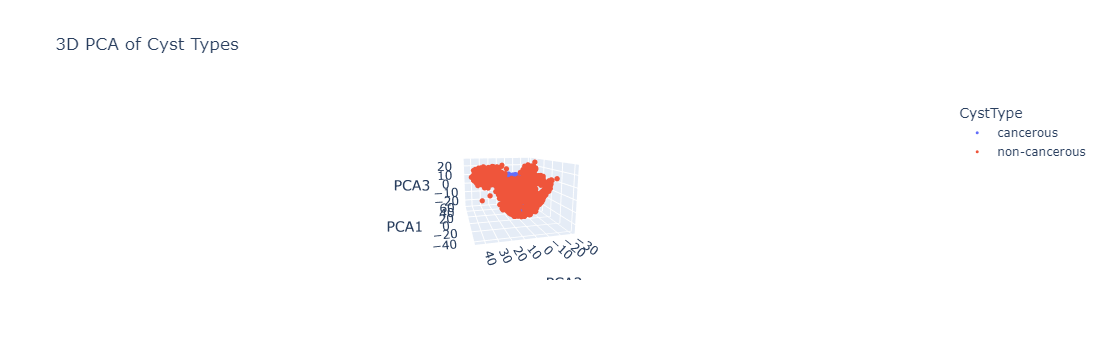

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['CystType', 'PatientID']))

# Applying PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

# Creating a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['CystType'] = merged_data['CystType'].values

# Creating an interactive 3D scatter plot with Plotly
fig = px.scatter_3d(pca_df, 
                    x='PCA1', 
                    y='PCA2', 
                    z='PCA3', 
                    color='CystType',
                    title='3D PCA of Cyst Types',
                    labels={'PCA1': 'PCA1', 'PCA2': 'PCA2', 'PCA3': 'PCA3'})

# Update the marker size
fig.update_traces(marker=dict(size=3))

# Show the plot
fig.show()


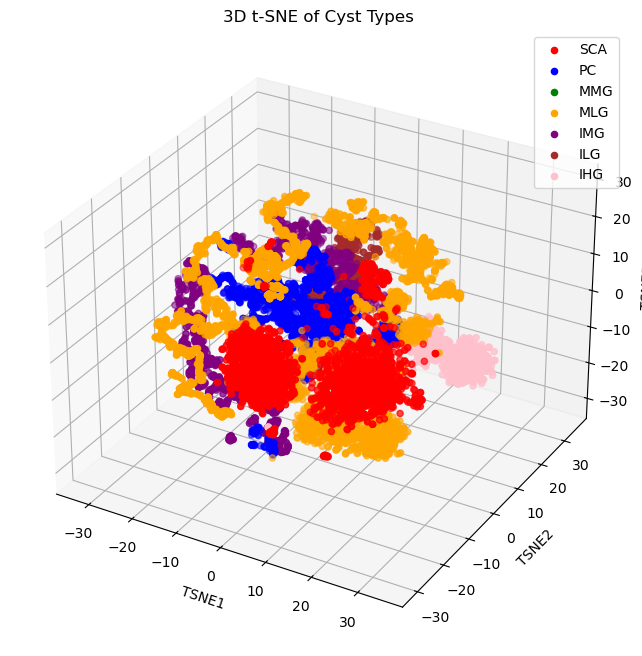

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Scale the data excluding 'CystType' and 'PatientID'
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['CystType', 'PatientID']))

# Apply t-SNE to reduce to 3 dimensions
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df['CystType'] = merged_data['CystType'].values

# Define contrasting colors
colors = {
    'SCA': 'red',
    'PC': 'blue',
    'MMG': 'green',
    'MLG': 'orange',
    'IMG': 'purple',
    'ILG': 'brown',
    'IHG': 'pink'
}

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cyst type with its corresponding color
for cyst_type, color in colors.items():
    indices = tsne_df['CystType'] == cyst_type
    ax.scatter(tsne_df.loc[indices, 'TSNE1'],
               tsne_df.loc[indices, 'TSNE2'],
               tsne_df.loc[indices, 'TSNE3'],
               label=cyst_type,
               color=color)

ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
ax.set_title('3D t-SNE of Cyst Types')
ax.legend()
plt.show()


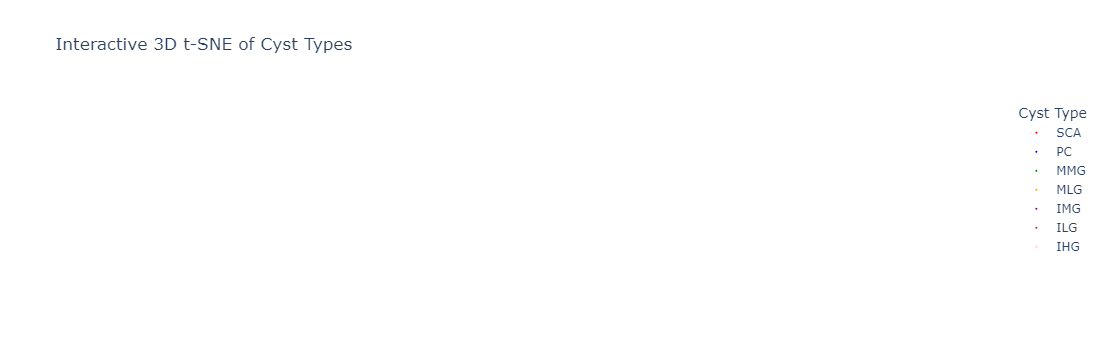

In [14]:
import plotly.graph_objs as go
import plotly.express as px

fig = go.Figure()

# Add each cyst type with its corresponding color
for cyst_type, color in colors.items():
    indices = tsne_df['CystType'] == cyst_type
    fig.add_trace(go.Scatter3d(
        x=tsne_df.loc[indices, 'TSNE1'],
        y=tsne_df.loc[indices, 'TSNE2'],
        z=tsne_df.loc[indices, 'TSNE3'],
        mode='markers',
        marker=dict(color=color, size=2), 
        name=cyst_type
    ))

# Set plot layout
fig.update_layout(
    title='Interactive 3D t-SNE of Cyst Types',
    scene=dict(
        xaxis_title='TSNE1',
        yaxis_title='TSNE2',
        zaxis_title='TSNE3'
    ),
    legend_title='Cyst Type'
)

fig.show()

In [18]:
# PCA Analysis
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['CystType', 'PatientID']))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CystType'] = merged_data['CystType'].values


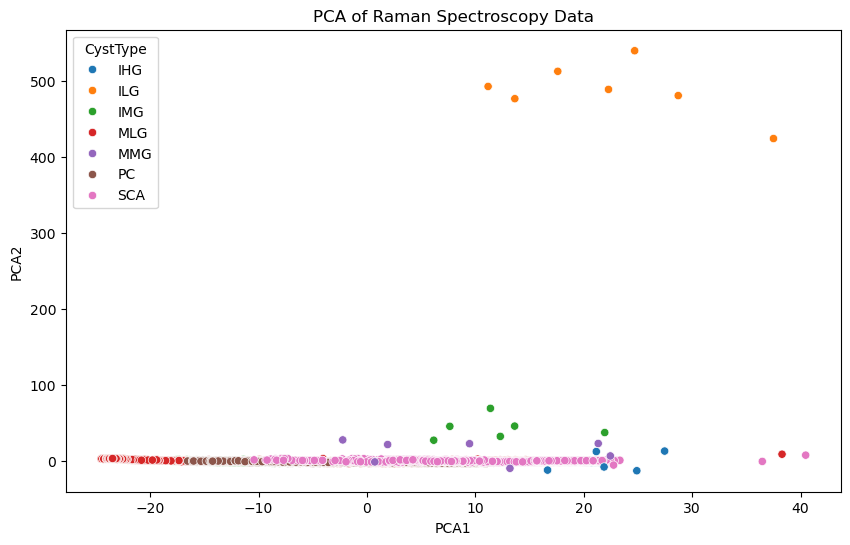

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='CystType', data=pca_df, palette='tab10', alpha=1)
plt.title('PCA of Raman Spectroscopy Data')
plt.show()

## Model Training

In [20]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
RS = 42

In [ ]:
qda_params = {'reg_param': [0.0, 0.1, 0.5, 1.0]}
qda_search = GridSearchCV(QDA(), qda_params, scoring='accuracy', cv=cv, n_jobs=-1)
qda_search.fit(X_train, y_train)
best_qda = qda_search.best_estimator_

qda_pred = best_qda.predict(X_test)
qda_acc = accuracy_score(y_test, qda_pred)
qda_f1 = f1_score(y_test, qda_pred, average='weighted')
qda_cm = confusion_matrix(y_test, qda_pred)


In [21]:
rf_params = {'max_depth': [10, 20, None], 'max_features': ['sqrt'], 'criterion': ['gini']}
rf_search = GridSearchCV(RandomForestClassifier(random_state=RS), rf_params, scoring='accuracy', cv=cv, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

rf_pred = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
rf_cm = confusion_matrix(y_test, rf_pred)


In [22]:
print(rf_acc)

0.023395320935812838


In [19]:
ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
ada_search = GridSearchCV(AdaBoostClassifier(), ada_params, scoring='accuracy', cv=cv, n_jobs=-1)
ada_search.fit(X_train, y_train)
best_ada = ada_search.best_estimator_

ada_pred = best_ada.predict(X_test)
ada_acc = accuracy_score(y_test, ada_pred)
ada_f1 = f1_score(y_test, ada_pred, average='weighted')
ada_cm = confusion_matrix(y_test, ada_pred)

In [ ]:
print(ada_cm)

[[ 593    0]
 [1089 5632]]


In [20]:
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
gb_search = GridSearchCV(GradientBoostingClassifier(), gb_params, scoring='accuracy', cv=cv, n_jobs=-1)
gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_

gb_pred = best_gb.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred, average='weighted')
gb_cm = confusion_matrix(y_test, gb_pred)

In [ ]:
print(gb_cm)

[[ 593    0]
 [1089 5632]]


In [21]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [22]:
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
xgb_search = GridSearchCV(XGBClassifier(), xgb_params, scoring='accuracy', cv=cv, n_jobs=-1)
xgb_search.fit(X_train, y_train_encoded)
best_xgb = xgb_search.best_estimator_

xgb_pred = best_xgb.predict(X_test)
xgb_acc = accuracy_score(y_test_encoded, xgb_pred)
xgb_f1 = f1_score(y_test_encoded, xgb_pred, average='weighted')
xgb_cm = confusion_matrix(y_test_encoded, xgb_pred)


In [ ]:
X_train = np.nan_to_num(X_train,nan= 100)
X_test= np.nan_to_num(X_test,nan= 100)
knn_params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn_search = GridSearchCV(KNeighborsClassifier(), knn_params, scoring='accuracy', cv=cv, n_jobs=-1)
knn_search.fit(X_train, y_train)
best_knn = knn_search.best_estimator_


knn_pred = best_knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred, average='weighted')  
knn_cm = confusion_matrix(y_test, knn_pred)

In [ ]:
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_search = GridSearchCV(SVC(probability=True), svm_params, scoring='accuracy', cv=cv, n_jobs=-1)
svm_search.fit(X_train, y_train)
best_svm = svm_search.best_estimator_

svm_pred = best_svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')
svm_cm = confusion_matrix(y_test, svm_pred)

In [ ]:
base_models = [
    ('qda', best_qda),
    ('svm', best_svm),
    ('rf', best_rf),
    ('ada', best_ada),
    ('gb', best_gb),
    ('xgb', best_xgb),
    ('knn', best_knn)
]

In [ ]:
# Create the voting ensemble classifier
ensemble_clf = VotingClassifier(estimators=base_models, voting='soft')
ensemble_clf.fit(X_train, y_train)
ensemble_pred = ensemble_clf.predict(X_test)
ensemble_acc = accuracy_score(y_test, ensemble_pred)
ensemble_f1 = f1_score(y_test, ensemble_pred, average='weighted')
ensemble_cm = confusion_matrix(y_test, ensemble_pred)

print(f"Ensemble Model Accuracy: {ensemble_acc:.4f}")
print(f"Ensemble Model F1 Score: {ensemble_f1:.4f}")
print("Ensemble Model Confusion Matrix:")
print(ensemble_cm)


In [ ]:
X_train_cnn = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(-1, X_test.shape[1], 1)
y_train_cnn = to_categorical(y_train.factorize()[0])
y_test_cnn = to_categorical(y_test.factorize()[0])

# Define the CNN model
cnn = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Explicitly define the input layer
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y_train_cnn.shape[1], activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, verbose=2)

cnn_pred = cnn.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)

cnn_acc = accuracy_score(np.argmax(y_test_cnn, axis=1), cnn_pred_classes)
cnn_f1 = f1_score(np.argmax(y_test_cnn, axis=1), cnn_pred_classes, average='weighted')
cnn_cm = confusion_matrix(np.argmax(y_test_cnn, axis=1), cnn_pred_classes)

In [ ]:
# Neural Network (NN)
nn = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train_cnn.shape[1], activation='softmax')
])

nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train_cnn, epochs=20, batch_size=32, verbose=2)
nn_pred = nn.predict(X_test)
nn_pred_classes = np.argmax(nn_pred, axis=1)
nn_acc = accuracy_score(np.argmax(y_test_cnn, axis=1), nn_pred_classes)
nn_f1 = f1_score(np.argmax(y_test_cnn, axis=1), nn_pred_classes, average='weighted')
nn_cm = confusion_matrix(np.argmax(y_test_cnn, axis=1), nn_pred_classes)

In [ ]:
# Plot Confusion Matrices
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for ax, cm, model in zip(axes, [qda_cm, svm_cm, rf_cm, ada_cm, gb_cm, xgb_cm, cnn_cm, nn_cm],
                         ['QDA', 'SVM', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CNN', 'NN']):
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix: {model}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

fig, ax = plt.subplots(figsize=(10, 6))

for model, preds in zip(['QDA', 'SVM', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CNN', 'NN'],
                        [qda_pred, svm_pred, rf_pred, ada_pred, gb_pred, xgb_pred, cnn_pred_classes, nn_pred_classes]):
    if preds.ndim == 1 or preds.shape[1] == 1:
        preds_bin = label_binarize(preds, classes=np.unique(y_test))
    else:
        preds_bin = preds

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], preds_bin[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{model} (Class {i+1}, AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curves')
ax.legend(loc='lower right')
plt.show()

In [ ]:
# Compare Metrics
metrics_df = pd.DataFrame({
    'Model': ['QDA', 'SVM', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CNN', 'NN'],
    'Accuracy': [qda_acc, svm_acc, rf_acc, ada_acc, gb_acc, xgb_acc, cnn_acc, nn_acc],
    'F1 Score': [qda_f1, svm_f1, rf_f1, ada_f1, gb_f1, xgb_f1, cnn_f1, nn_f1]
})

print(metrics_df)


In [ ]:
# Bar Chart of Accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='viridis')
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.show()